### Imports

In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import plot_top_2_eigenvectors, plot_power

from cycler import cycler
from scipy.sparse.linalg import eigsh

from ann import compute_mlp_activations, compute_margin
from utils import sorted_spectral_decomp, plot_3d_projected_response, plot_top_2_eigenvectors, plot_power

### Initialization

Initialization based on [Pehlevan et al](https://github.com/Pehlevan-Group/sample_efficient_pop_codes).

In [2]:
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

fig_dir = 'figures/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)


root = 'natural_images/'
f = root + 'natimg2800_M170714_MP032_2017-09-14.mat'
f2 = root + 'stimuli_class_assignment_confident.mat'
f3 = root + 'images_natimg2800_all.mat'
dat = sp.io.loadmat(f)

f3 = sp.io.loadmat(f3)
imgs = f3['imgs']


# classes maps stim id to a class

m2 = sp.io.loadmat(f2)
classes = m2['class_assignment'][0]
class_names = m2['class_names']



resp = dat['stim'][0]['resp'][0] # stim x neurons
spont = dat['stim'][0]['spont'][0] # timepts x neurons
istim = (dat['stim'][0]['istim'][0]).astype(np.int32) # stim ids
istim -= 1 # get out of MATLAB convention

# stim is preprocessed
istim = istim[:,0]
nimg = istim.max() # these are blank stims (exclude them)
resp = resp[istim<nimg, :]
istim = istim[istim<nimg]

# subtract spont (32D)
mu = spont.mean(axis=0)
sd = spont.std(axis=0) + 1e-6
resp = (resp - mu) / sd
spont = (spont - mu) / sd
sv,u = eigsh(spont.T @ spont, k=32)
resp = resp - (resp @ u) @ u.T

# mean center each neuron
resp -= resp.mean(axis=0)
resp = resp / (resp.std(axis = 0)+1e-6)



# get classes
class_stim = classes[istim]


# which experimental trials belong to which category
inds1 = [i for i in range(len(class_stim)) if class_stim[i] == 1]
inds2 = [i for i in range(len(class_stim)) if class_stim[i] == 7]
inds_12 = inds1 + inds2

# which images belong to which category
imgs_inds1 = [i for i in range(len(classes)) if classes[i] == 1]
imgs_inds2 = [i for i in range(len(classes)) if classes[i] == 7]

SEED = 42
np.random.seed(SEED)
A = imgs[:, 90:180, imgs_inds1]
B = imgs[:, 90:180, imgs_inds2]

y = class_stim[inds_12]
a = np.amin(y)
b = np.amax(y)

y = 2/(b-a)*(y-np.mean([a,b]))

fontsize = 6
myaxis_font=8
line_width= 1
plt.rcParams.update({'font.size': fontsize})
resp_12 = resp[inds_12,:]

### Reproduce Pehlevan et al

(1735, 1735)
(1735,)
(1735,)


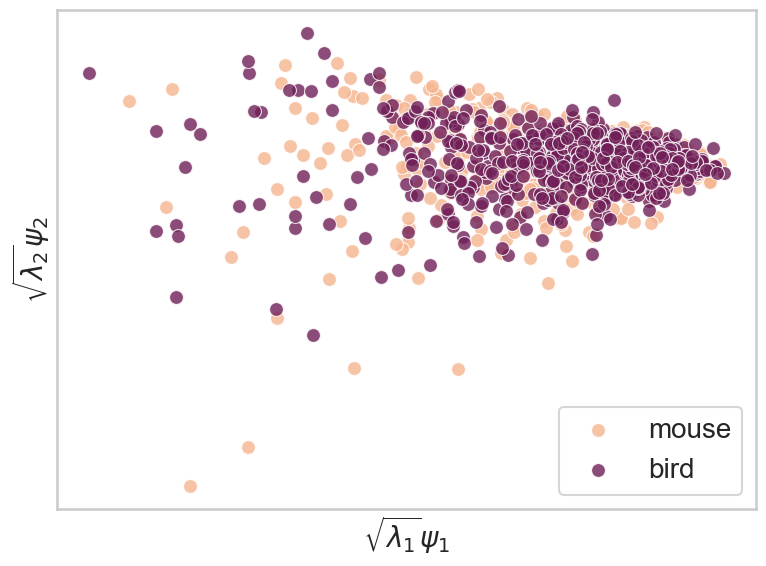

In [3]:
K, s, v = sorted_spectral_decomp(resp_12)
plot_top_2_eigenvectors(v, y, fig_name='top_2_eigenvectors_reproduced.pdf', title_postfix=' (Reproduced)', fig_dir='./ann_figures/')

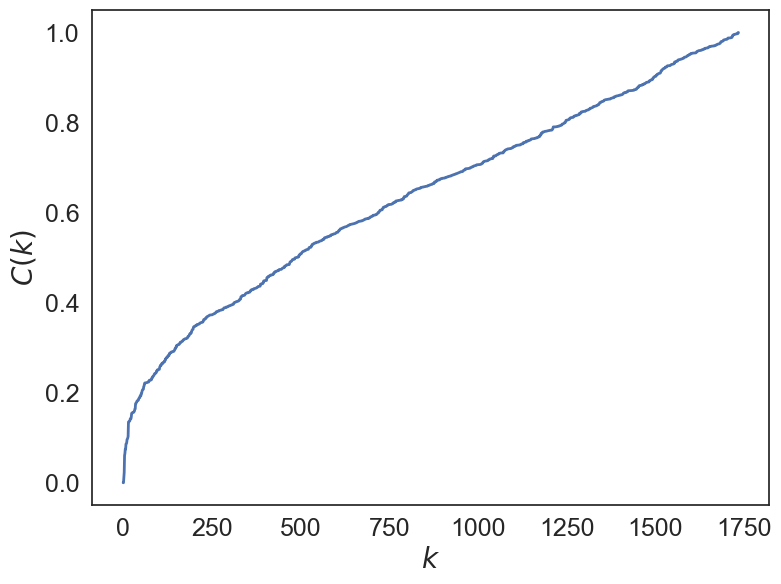

In [4]:
plot_power(v, y, fig_name='power_reproduced.pdf', title_postfix=' (Reproduced)', fig_dir='./ann_figures/')

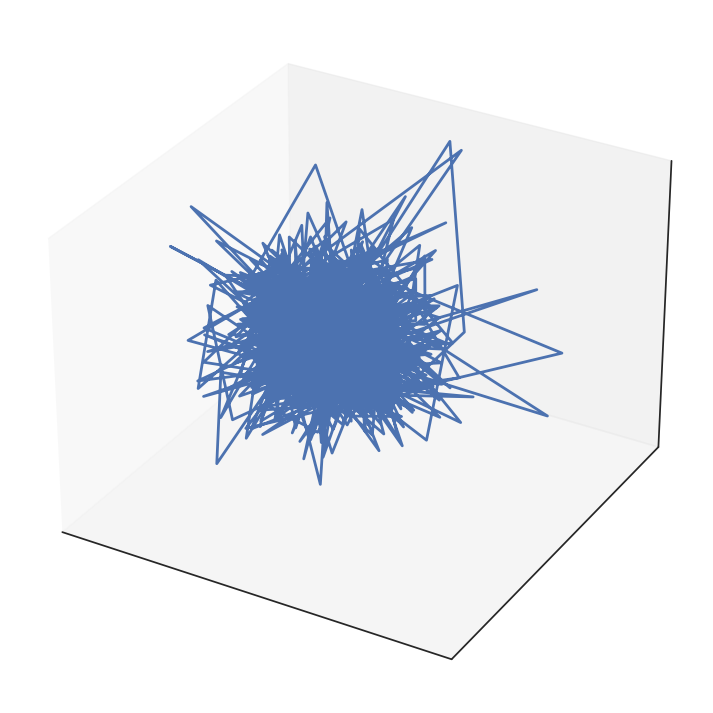

In [5]:
plot_3d_projected_response(resp_12.T, fig_name='3d_projection_population_codes.pdf', title_postfix=' in Mice')

### ANN Kernel

(1735, 1735)
(1735,)
(1735,)


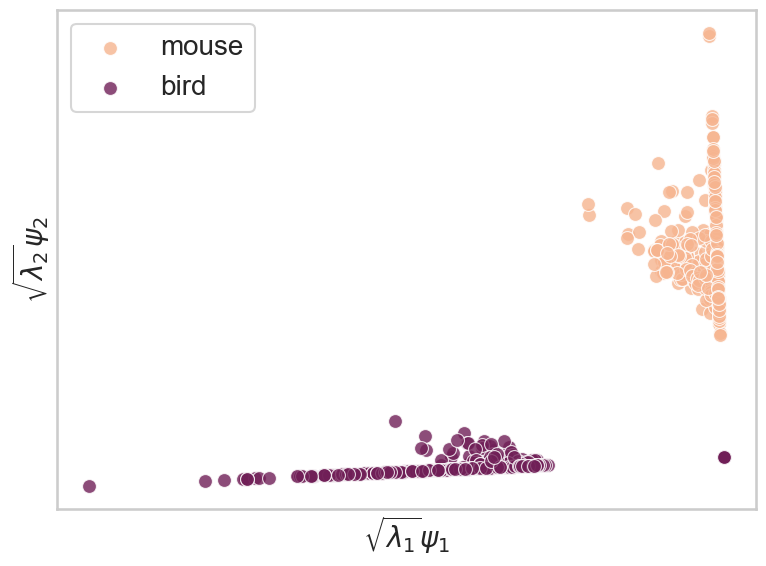

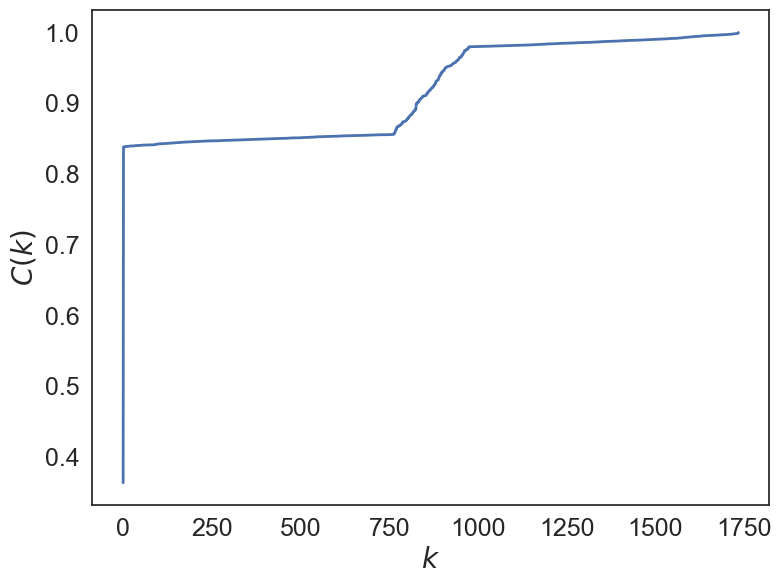

(1735, 1735)
(1735,)
(1735,)


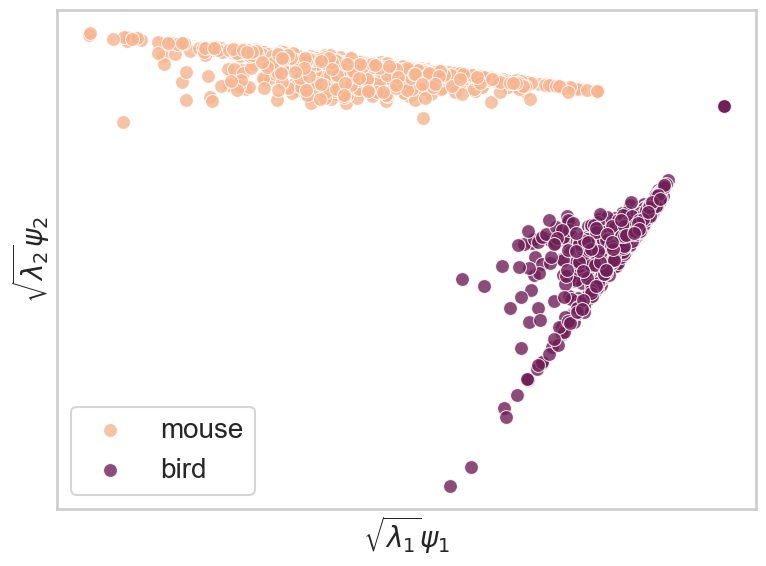

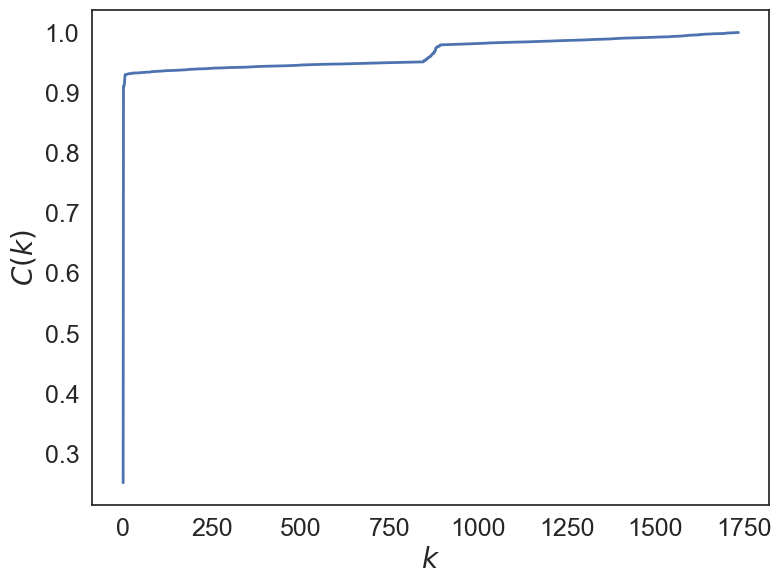

(1735, 1735)
(1735,)
(1735,)


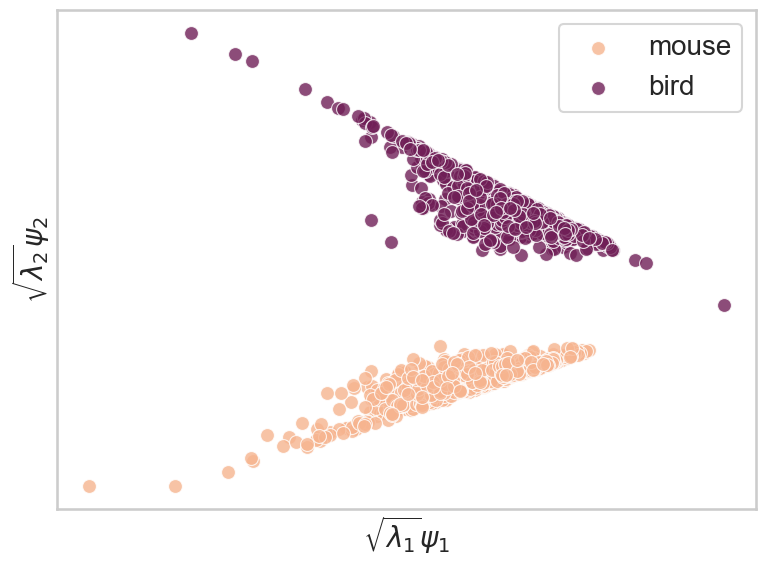

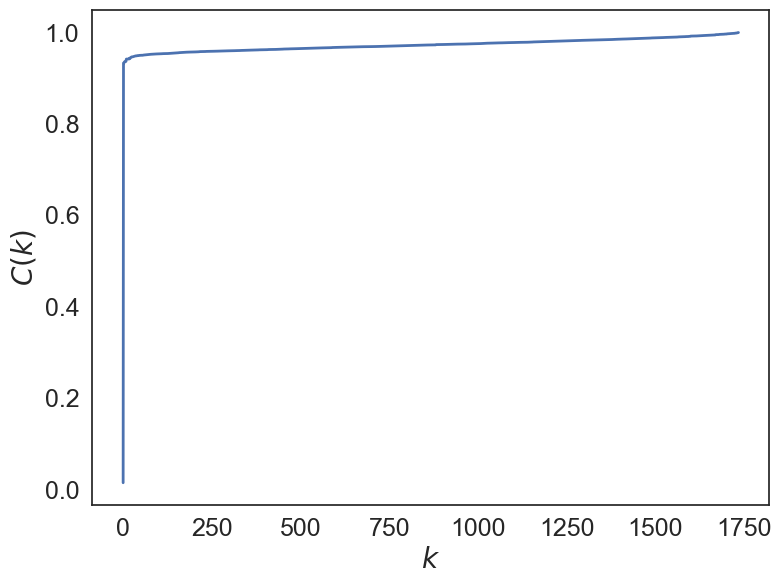

(1735, 1735)
(1735,)
(1735,)


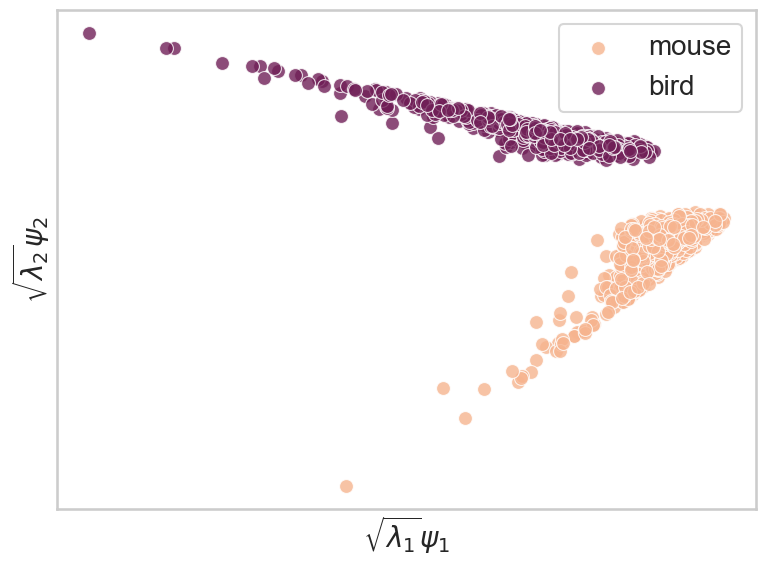

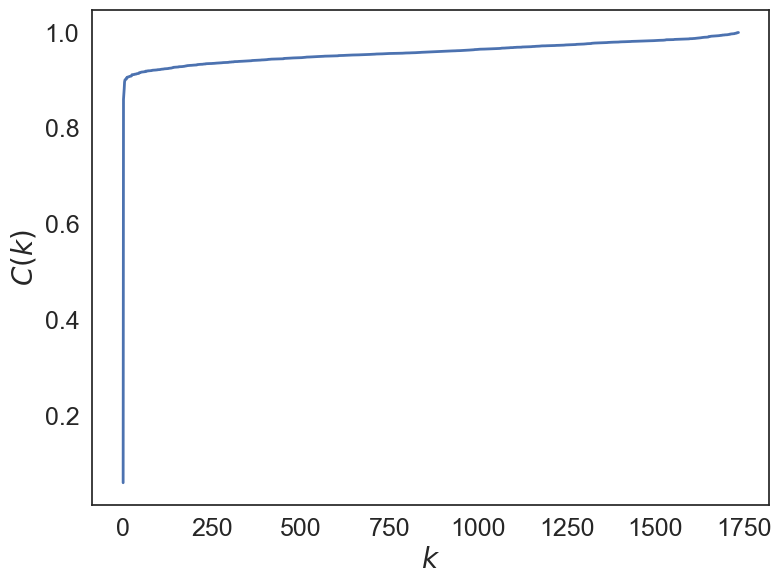

In [6]:
margins = []

for n_neurons in [2, 8, 32, 128]:

    activations = compute_mlp_activations(resp_12, y, n_neurons)
    K, s, v = sorted_spectral_decomp(activations)
    plot_top_2_eigenvectors(v, y, fig_name=f'top_2_eigenvectors_ann_{n_neurons}_neurons.pdf', title_postfix=f' (ANN, {n_neurons} Neurons)')
    plot_power(v, y, fig_name=f'power_ann_{n_neurons}_neurons.pdf', title_postfix=f' (ANN, {n_neurons} Neurons)')


    X = v[:, :2]  # Top two eigenvectors
    margin = compute_margin(X, y)  # Compute margin
    margins.append(margin)

In [7]:
for n_neurons, margin in zip([2, 8, 32, 128], margins):
    print(f"Margin for {n_neurons} neurons: {margin:.3f}")

Margin for 2 neurons: 0.032
Margin for 8 neurons: 0.031
Margin for 32 neurons: 0.031
Margin for 128 neurons: 0.033


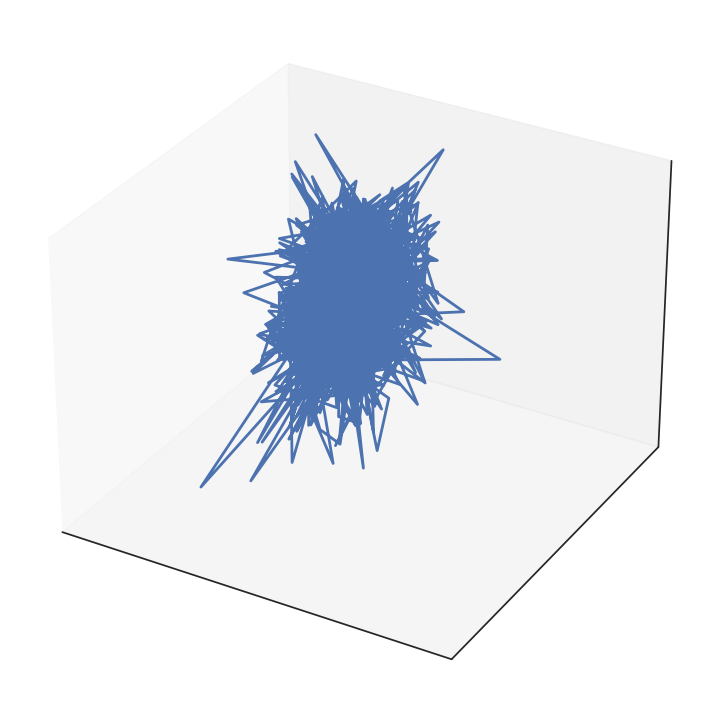

In [8]:
activations = compute_mlp_activations(resp_12, y, 32)
plot_3d_projected_response(activations.T, fig_name='3d_projection_ann_codes.pdf', title_postfix=' in ANN Kernel', fig_dir='./ann_figures/')

### SNN Kernel

In [9]:
from snn import SNN

N = resp_12.shape[1]  # Number of neurons
P = 100 # Number of patterns to use

# Normalize input data to [0, 1] for rate coding
samples = np.random.choice(np.arange(resp_12.shape[0]), P, replace=False)
responses = resp_12.copy()[samples, :]
y_class = y[samples]
rates = (responses - np.min(responses)) / (np.max(responses) - np.min(responses))


# Originally 784
n_input = N # input layer (one neuron per image pixel)
n_e = 128 # excitatory neurons
n_i = n_e # inhibitory neurons


Selected neurons: [39 20 14 96]
Running simulation for P = 10...


WARNING    'dt' is an internal variable of group 'INPUT', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


snn [39 20 14 96]
... starting training ...


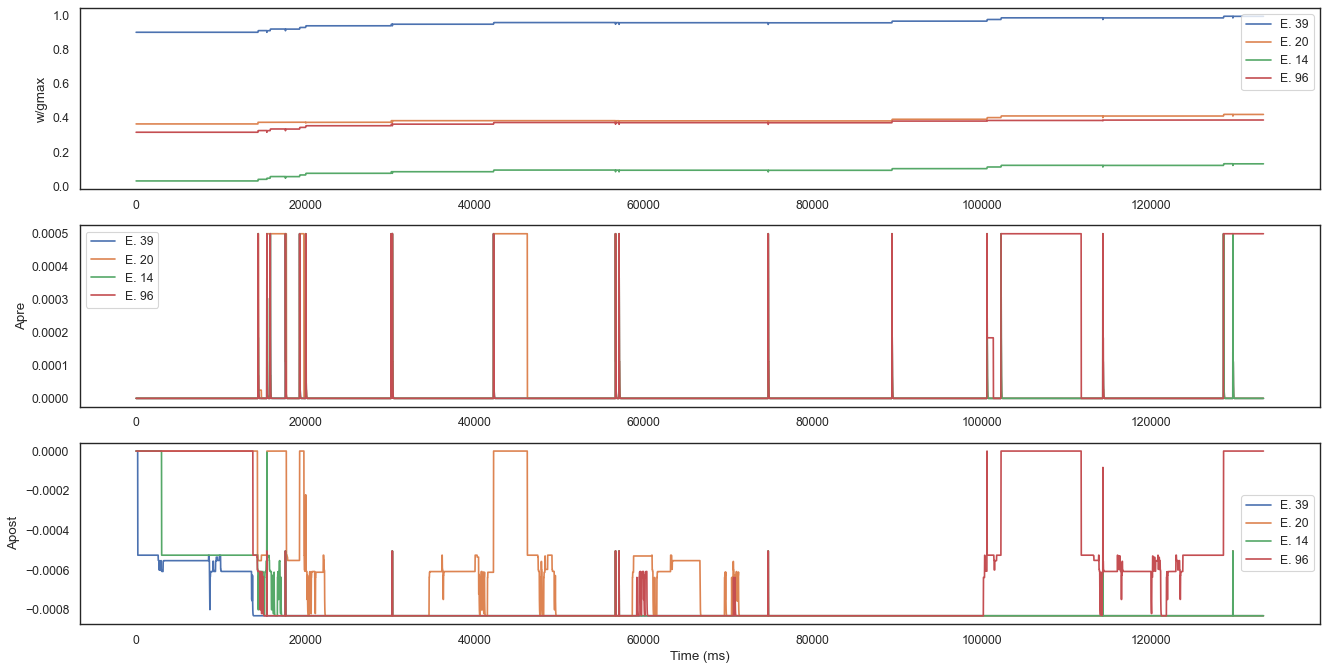

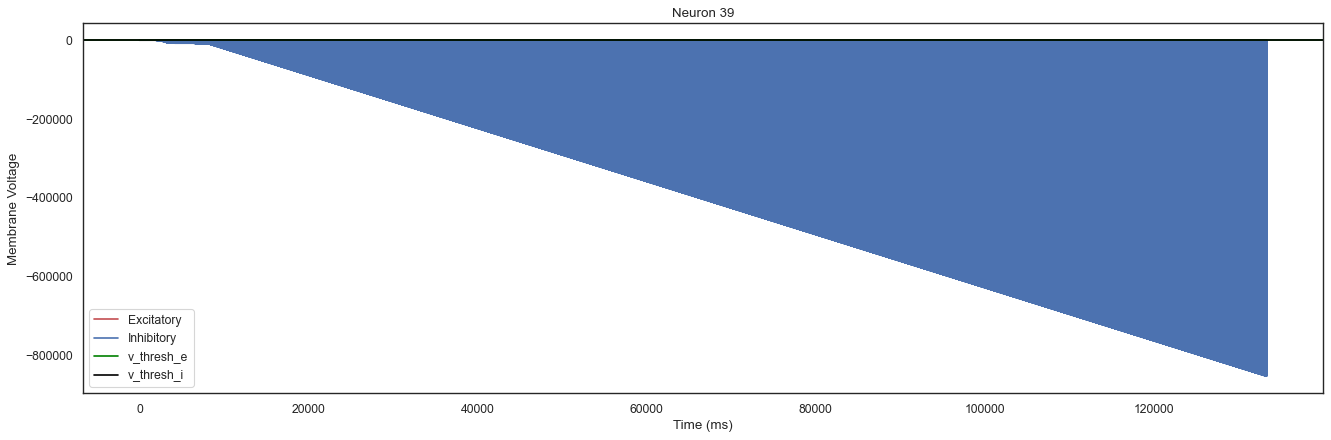

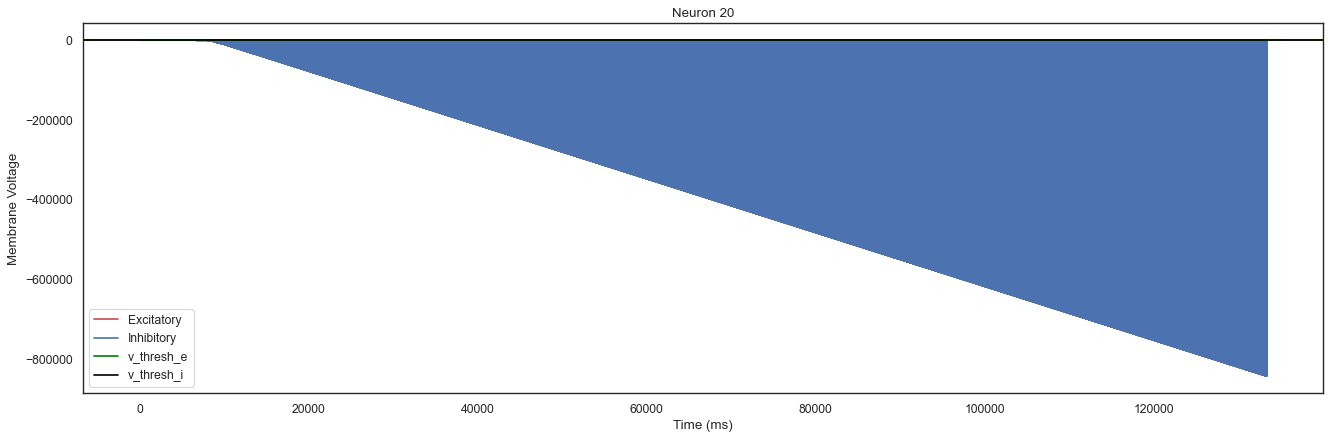

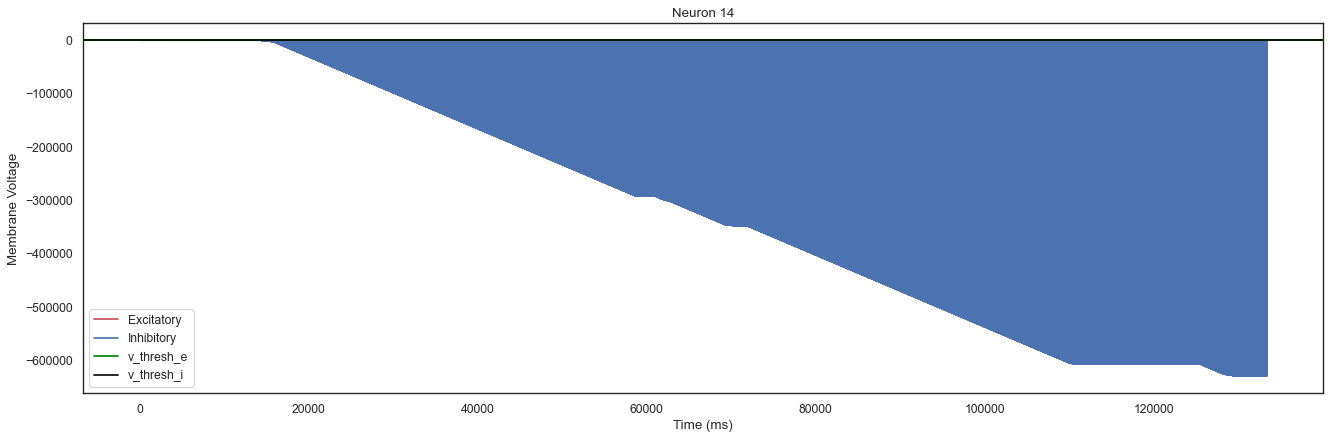

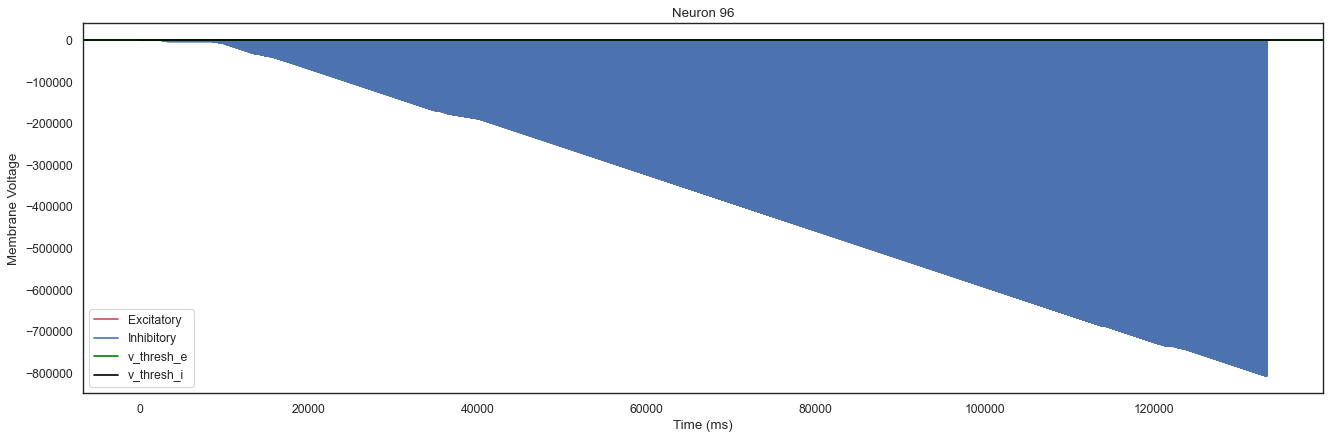

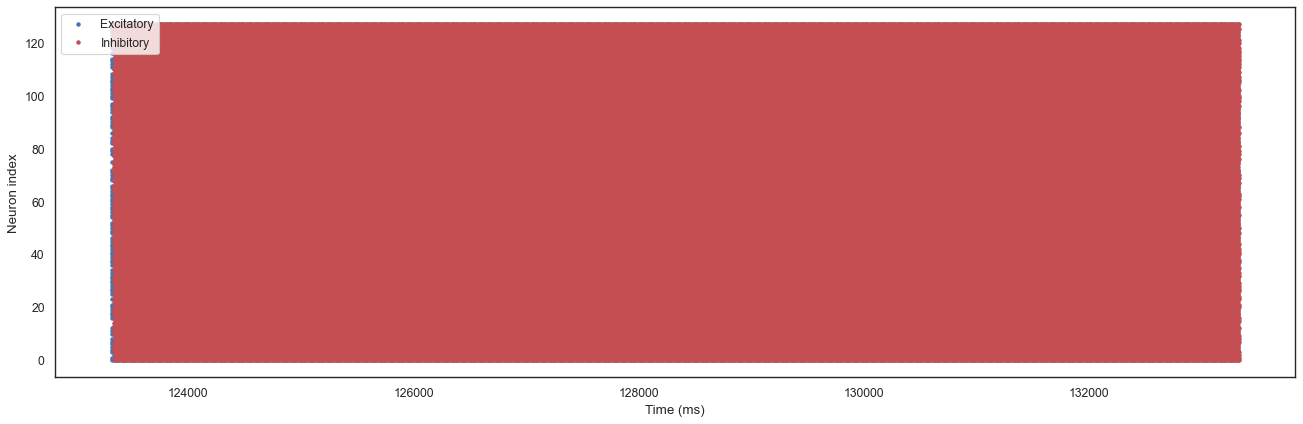

Presenting labels to network...
.... starting presentation/labeling phase ...
0
(10, 10)
(10,)
(10,)


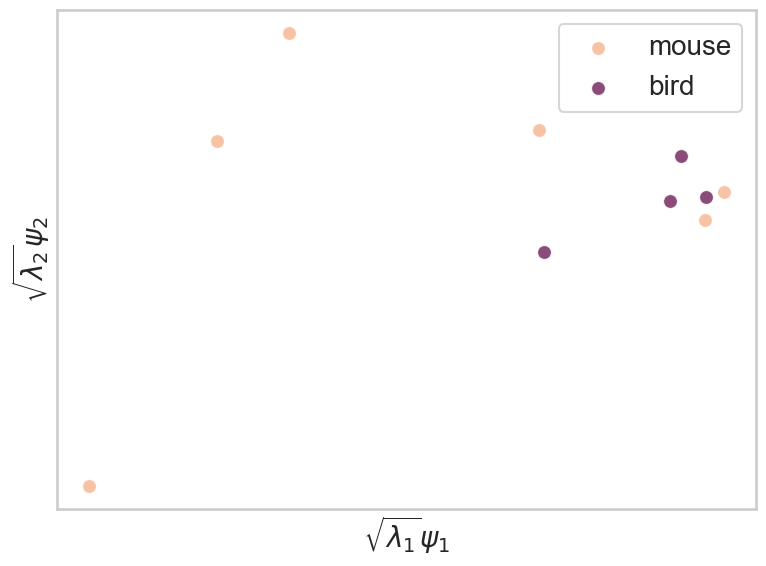

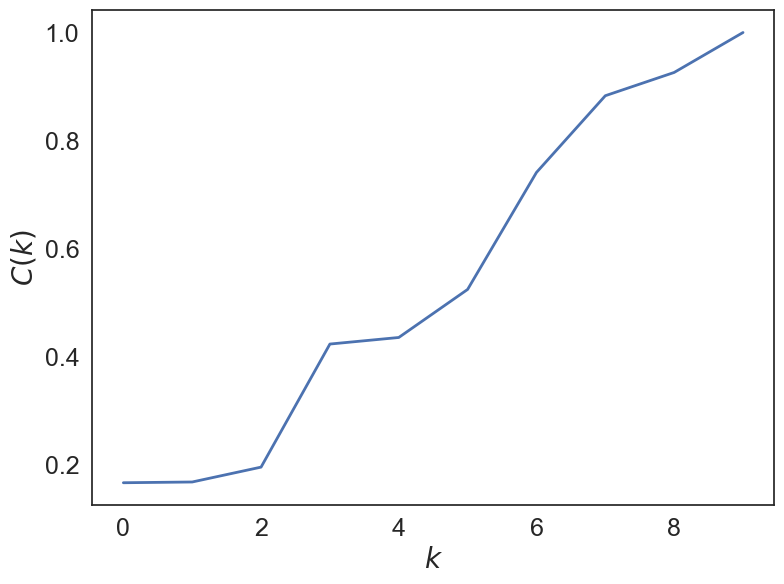

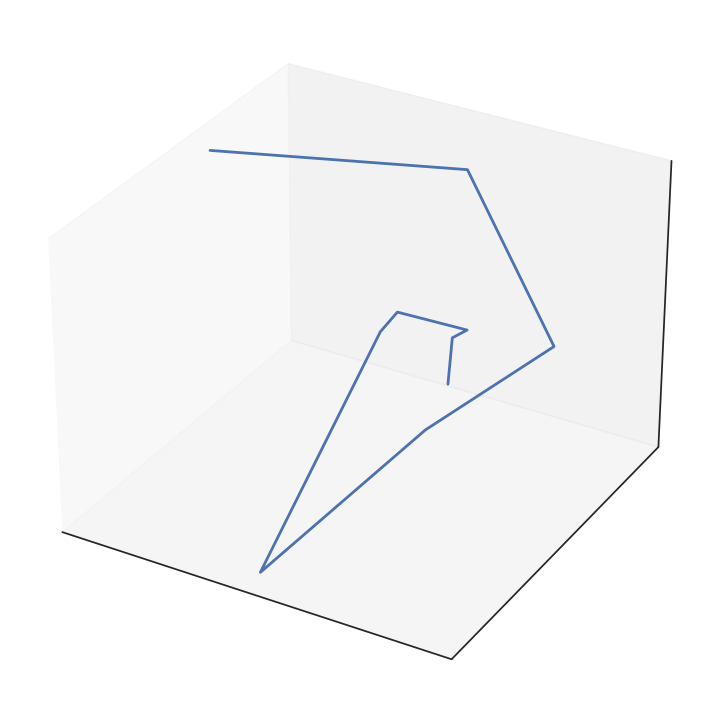

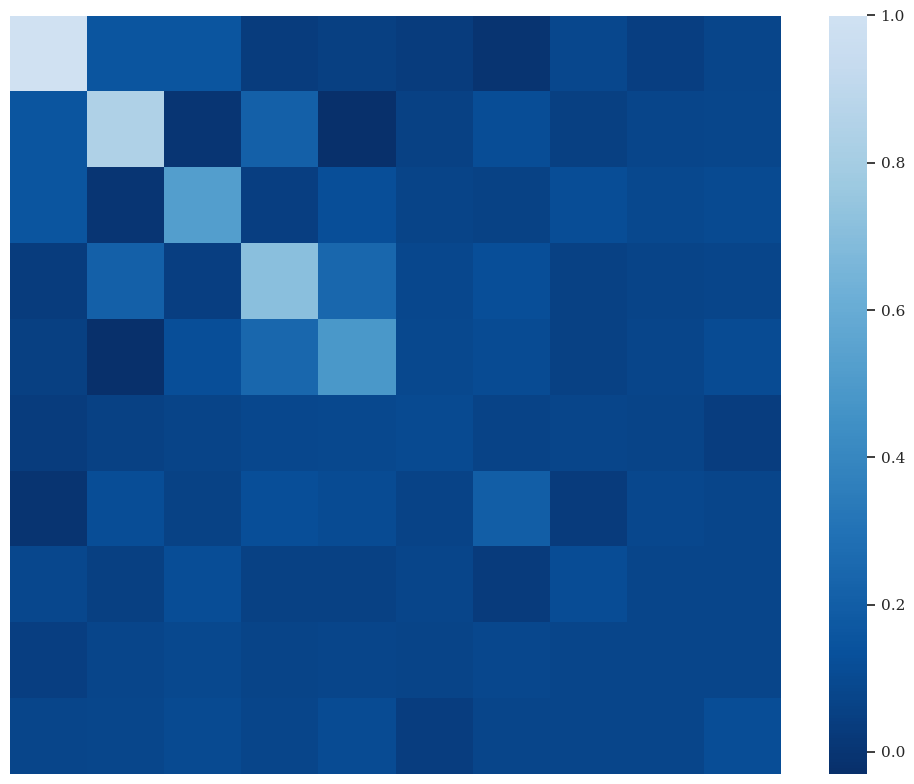

Running simulation for P = 25...
snn [39 20 14 96]
... starting training ...
0


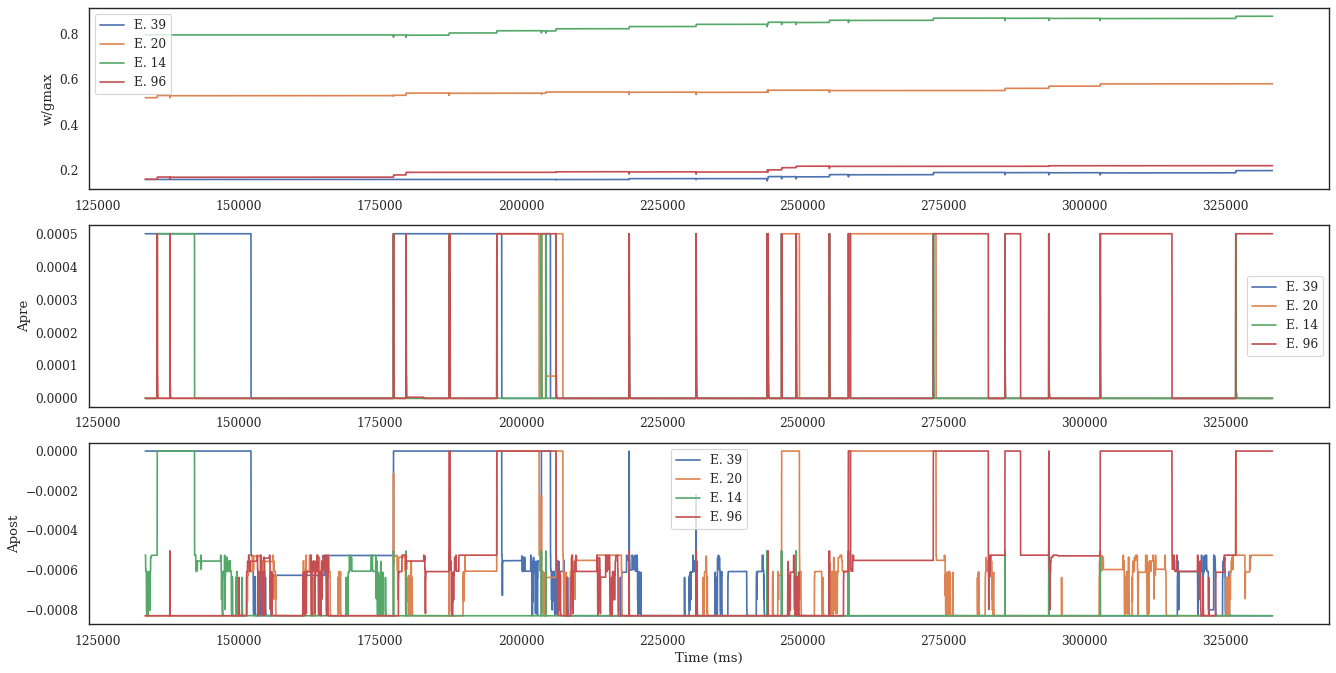

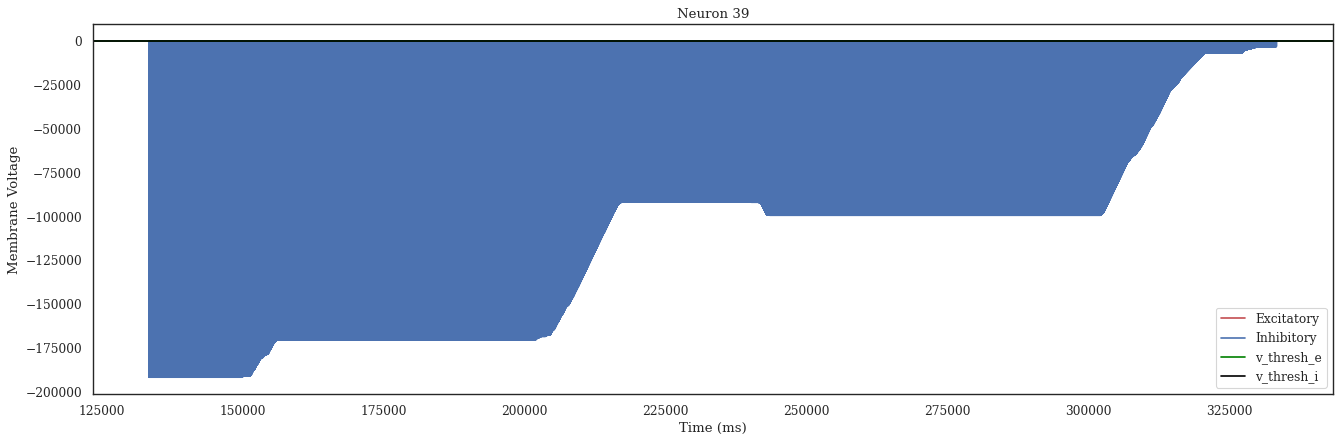

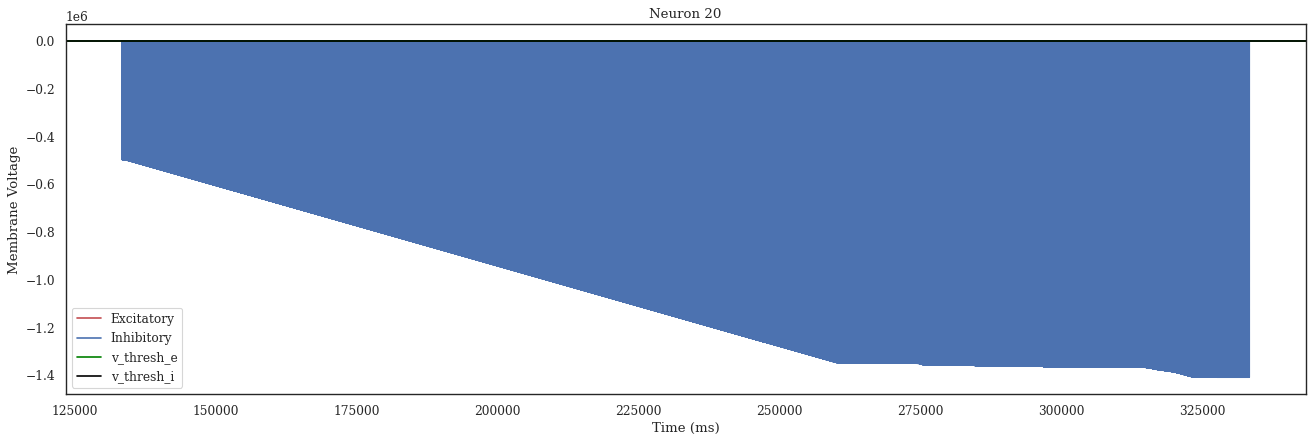

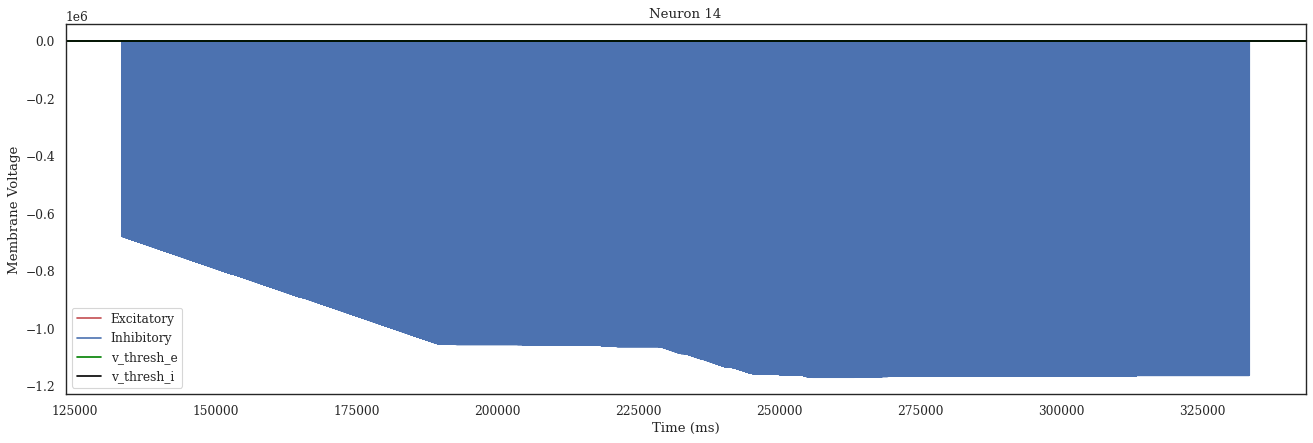

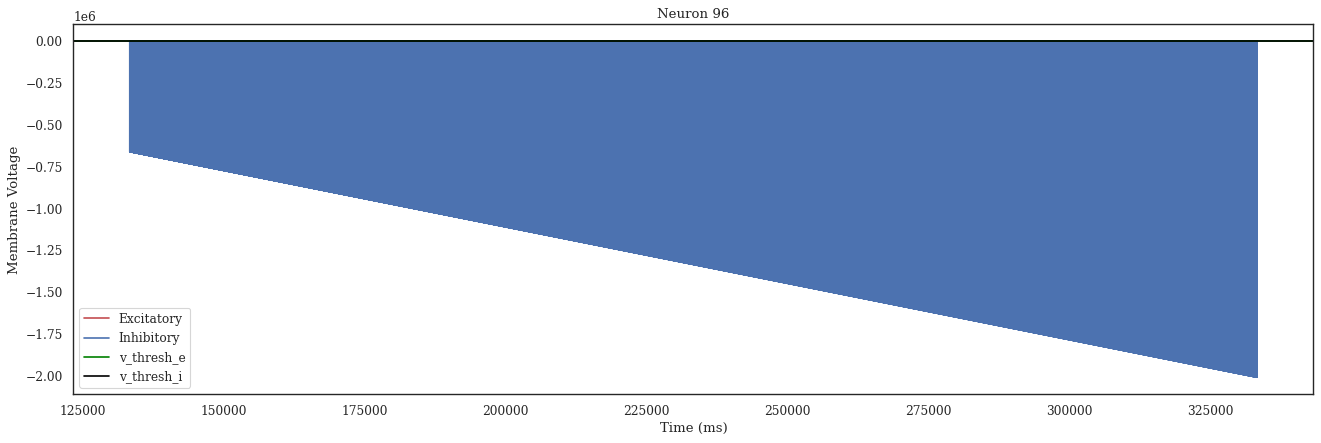

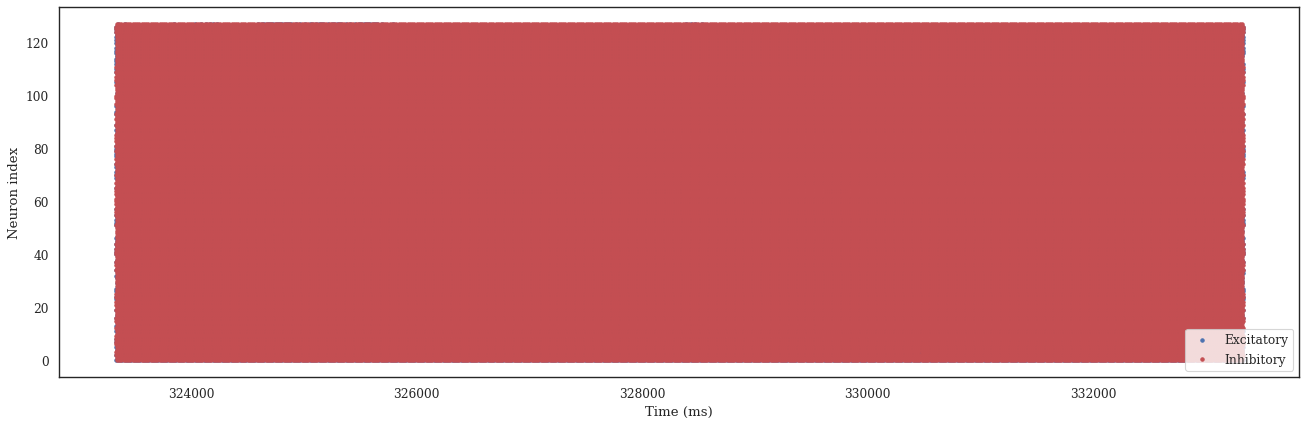

Presenting labels to network...
.... starting presentation/labeling phase ...
0
10
20
(25, 25)
(25,)
(25,)


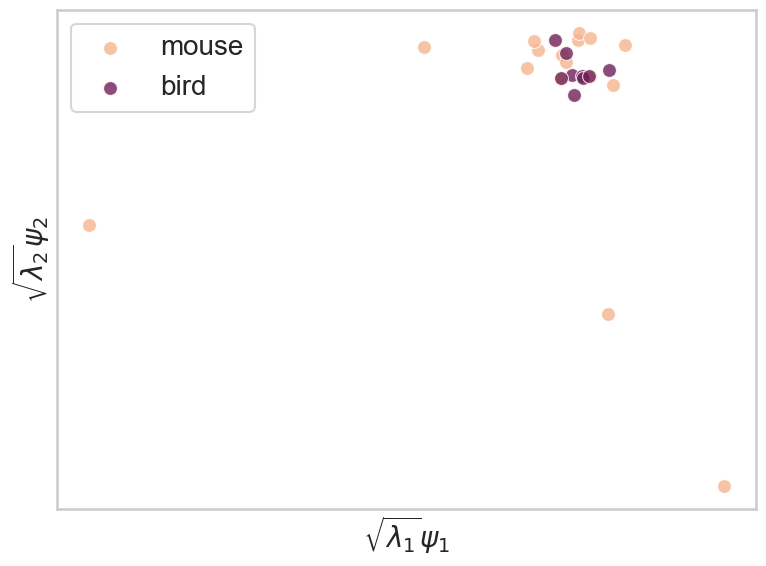

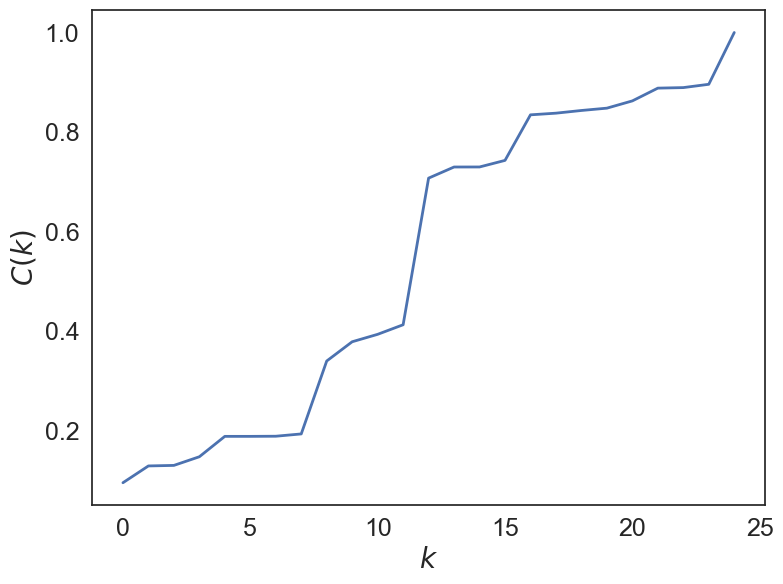

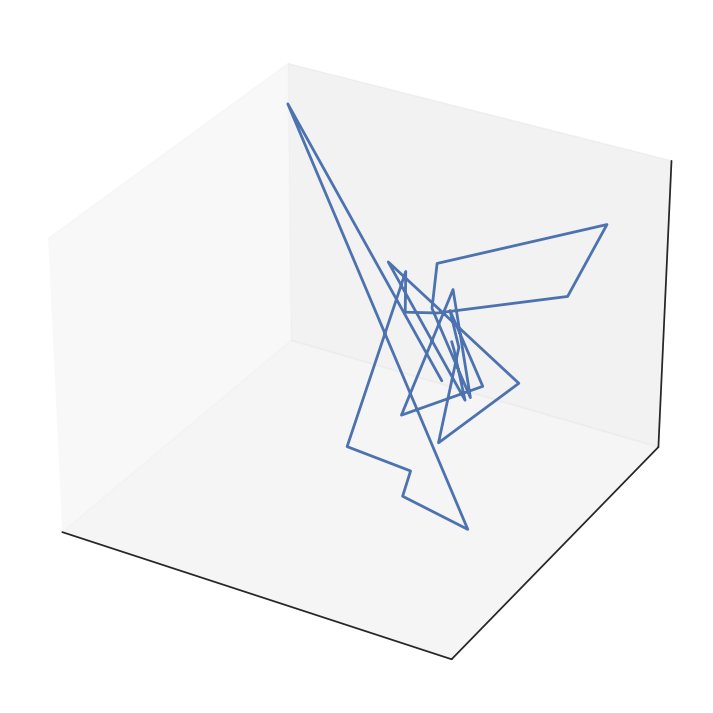

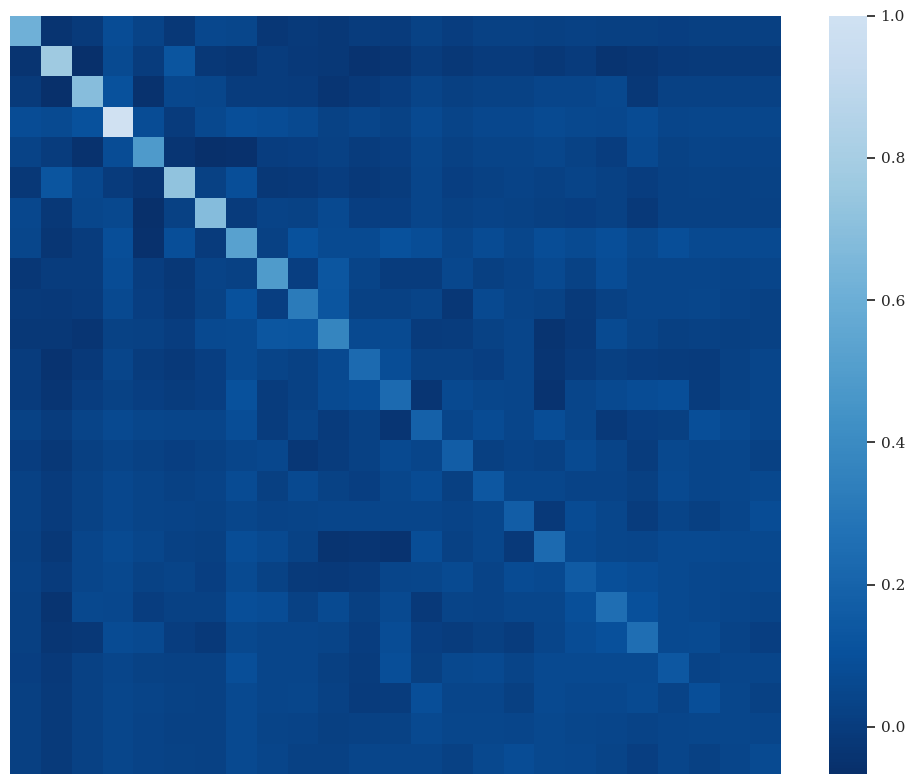

Running simulation for P = 50...
snn [39 20 14 96]
... starting training ...
0
10
20
30


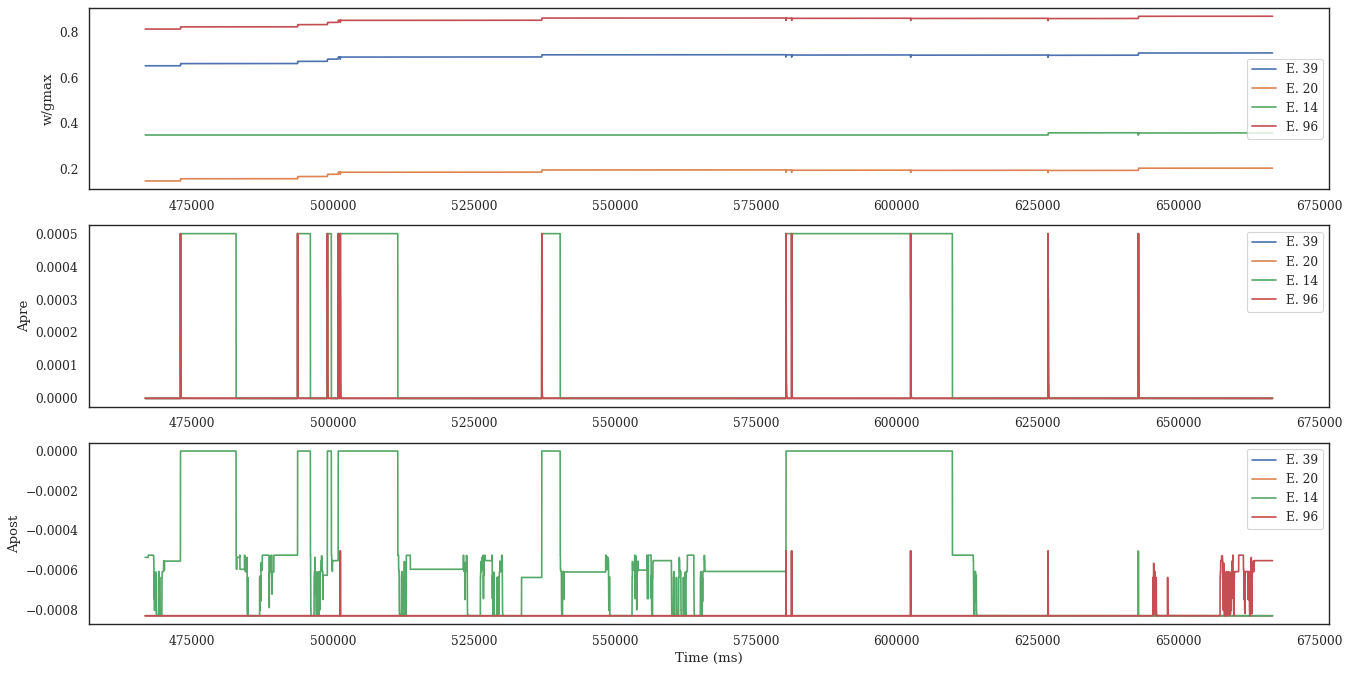

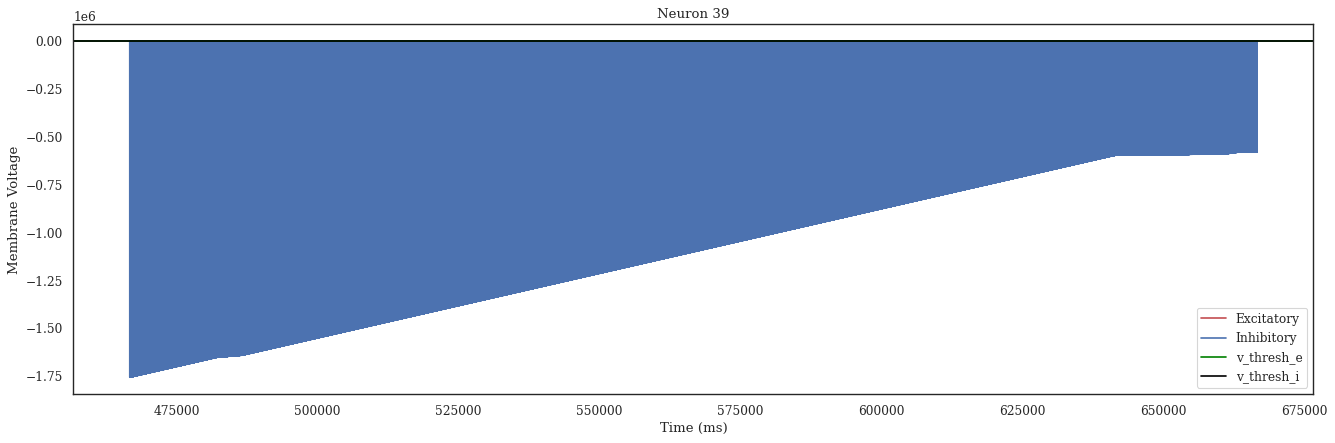

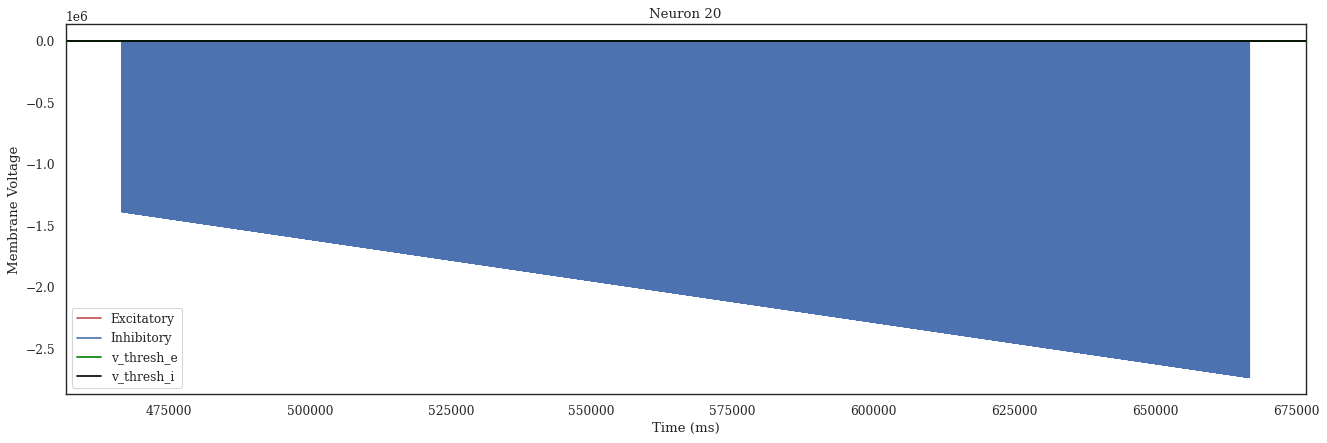

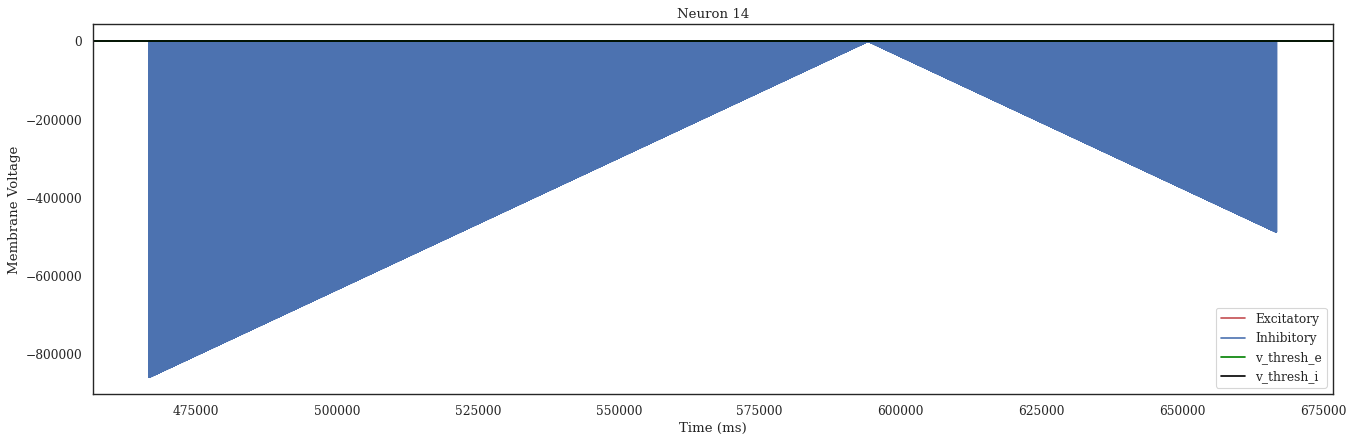

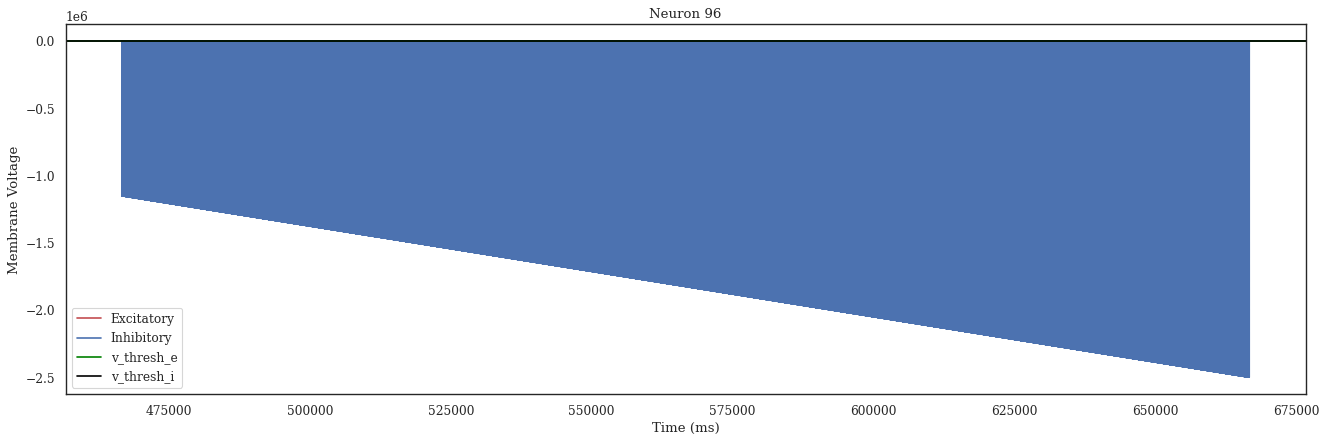

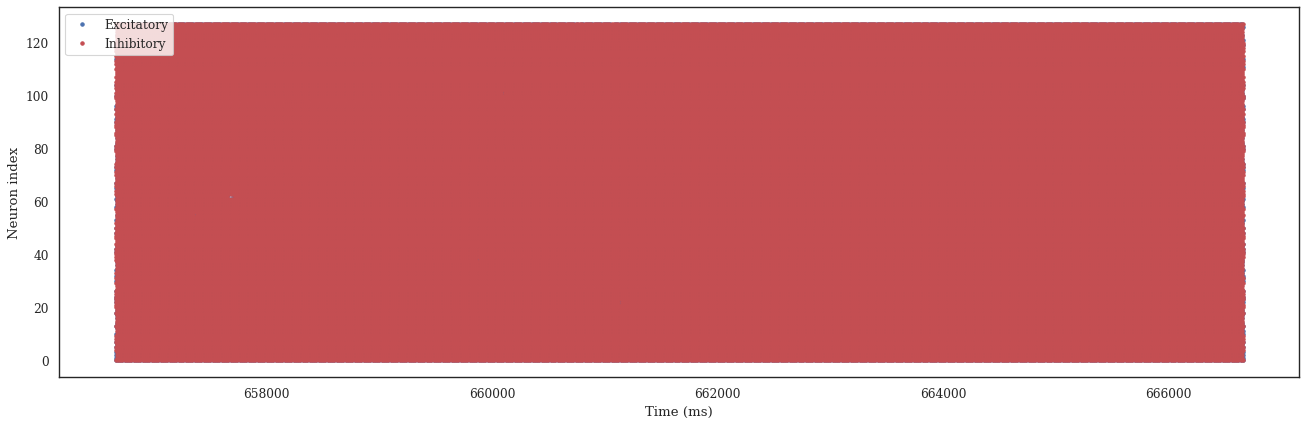

Presenting labels to network...
.... starting presentation/labeling phase ...
0
10
20
30
40
(50, 50)
(50,)
(50,)


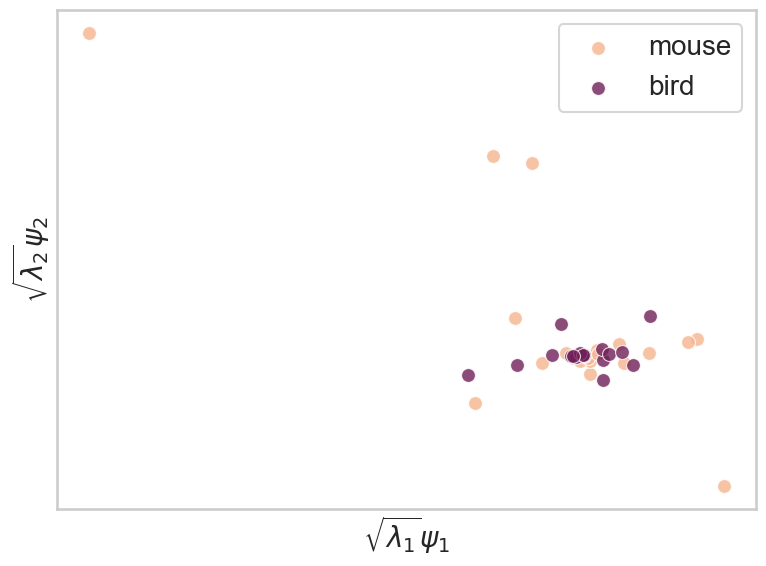

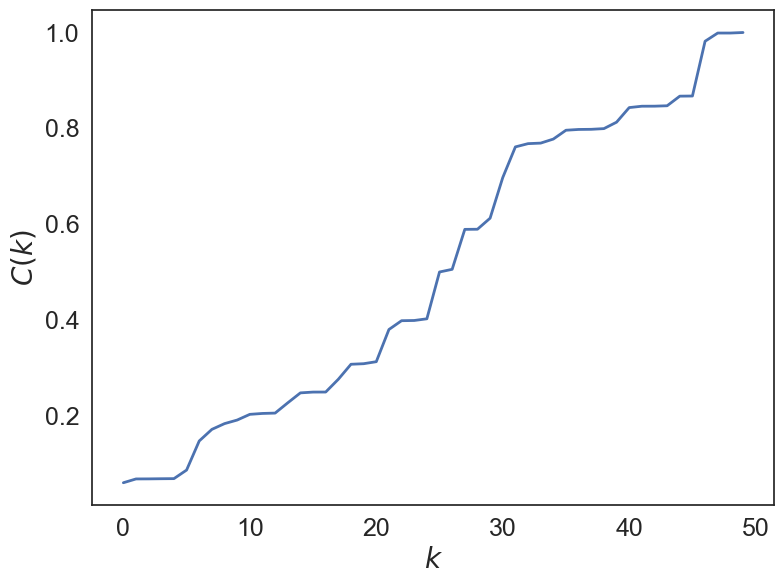

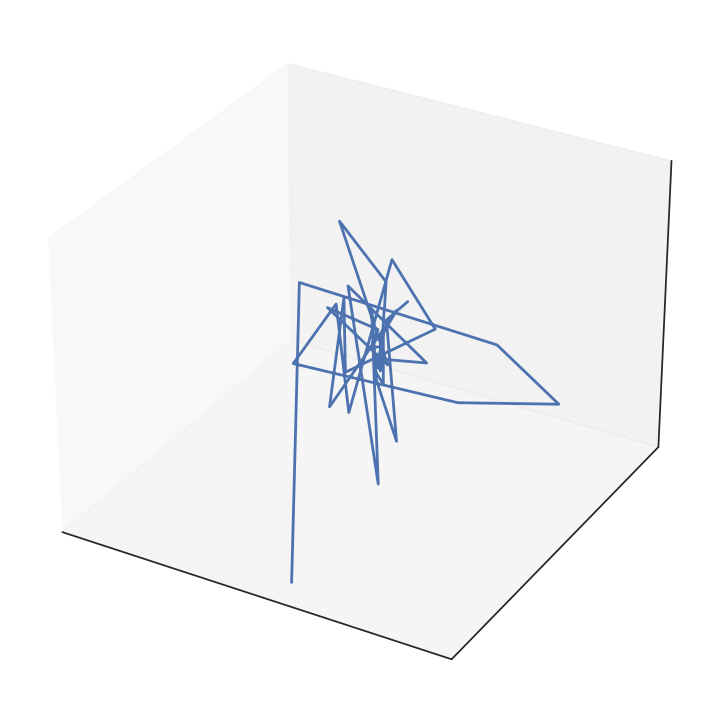

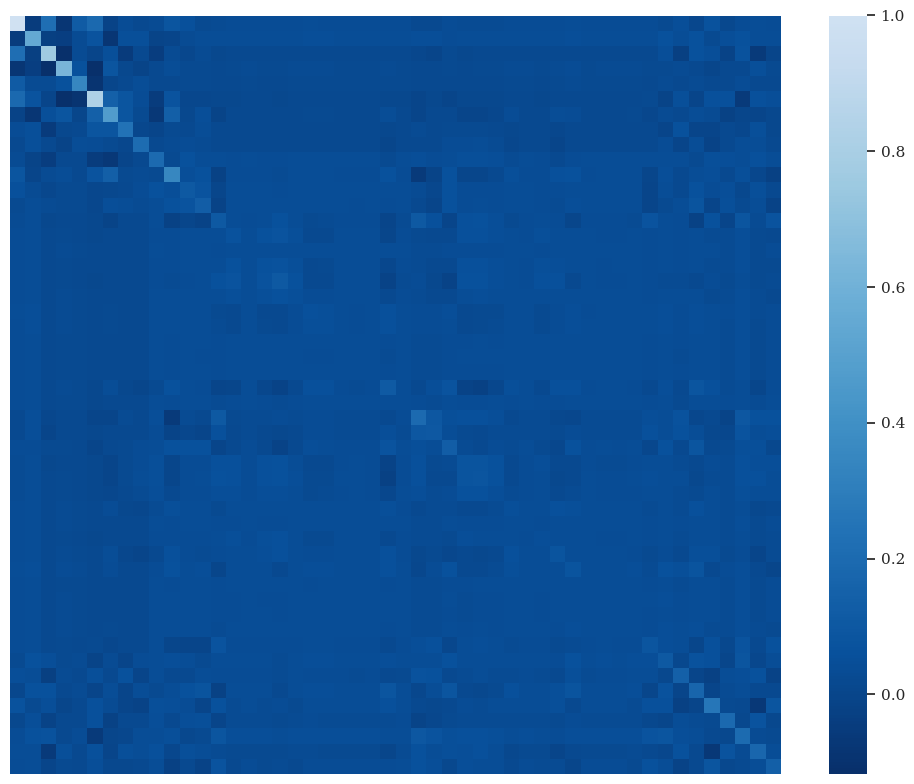

Running simulation for P = 100...
snn [39 20 14 96]
... starting training ...
0
10
20
30
40
50
60
70
80


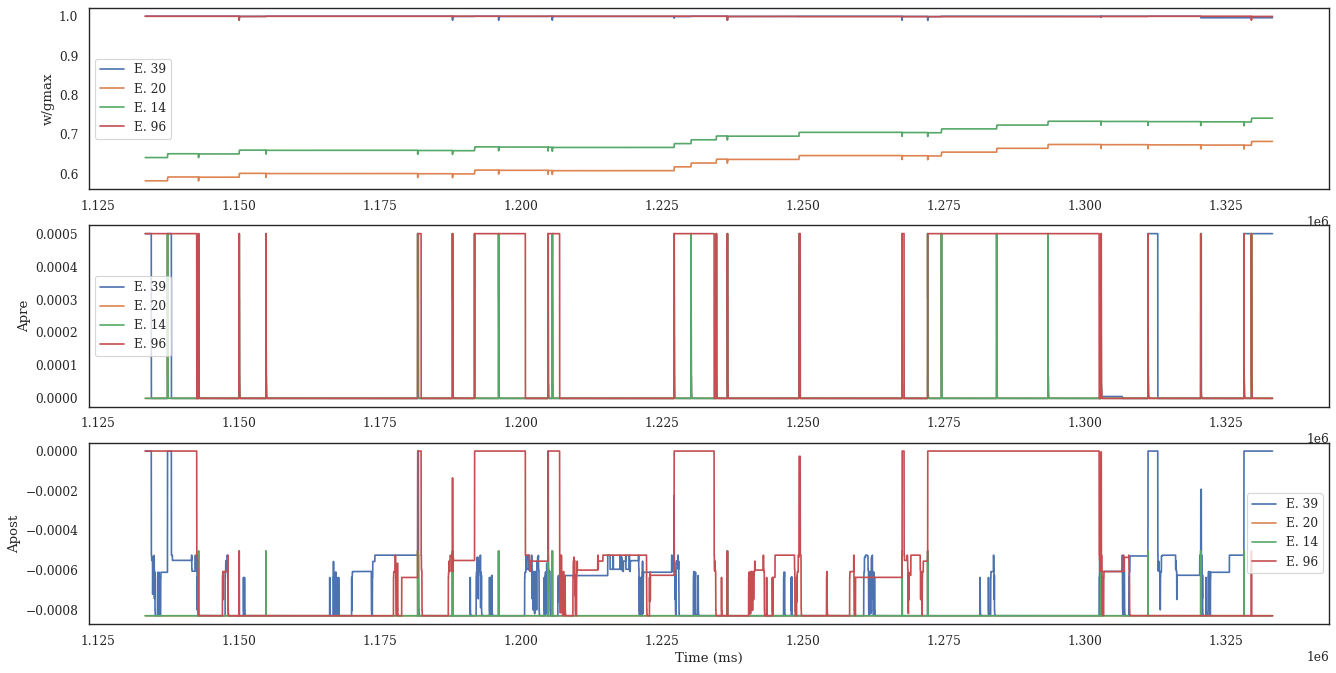

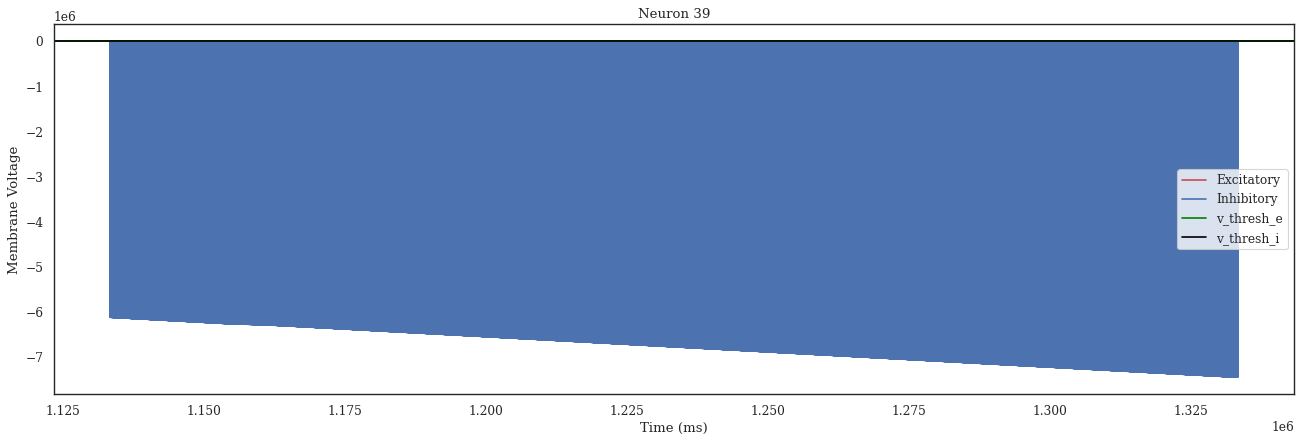

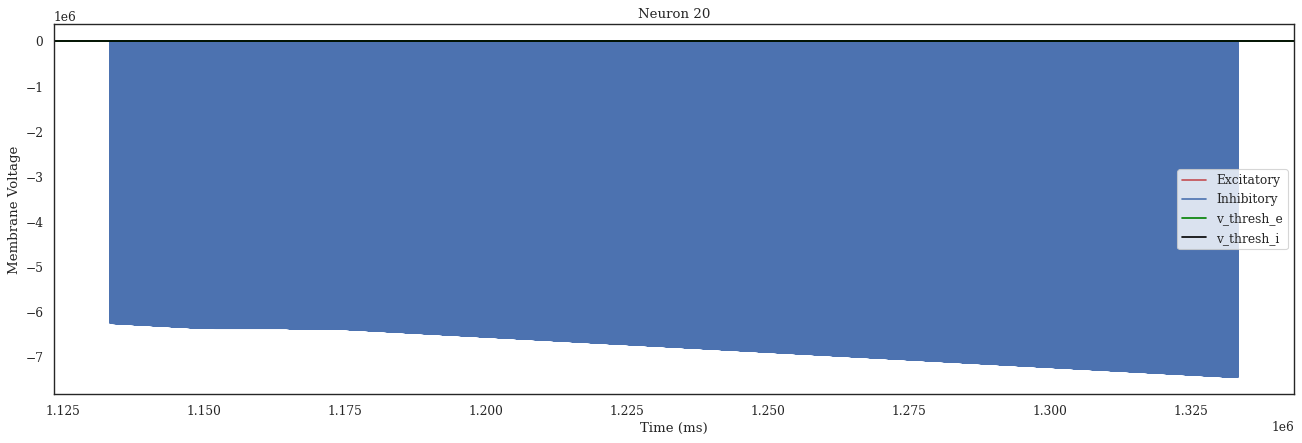

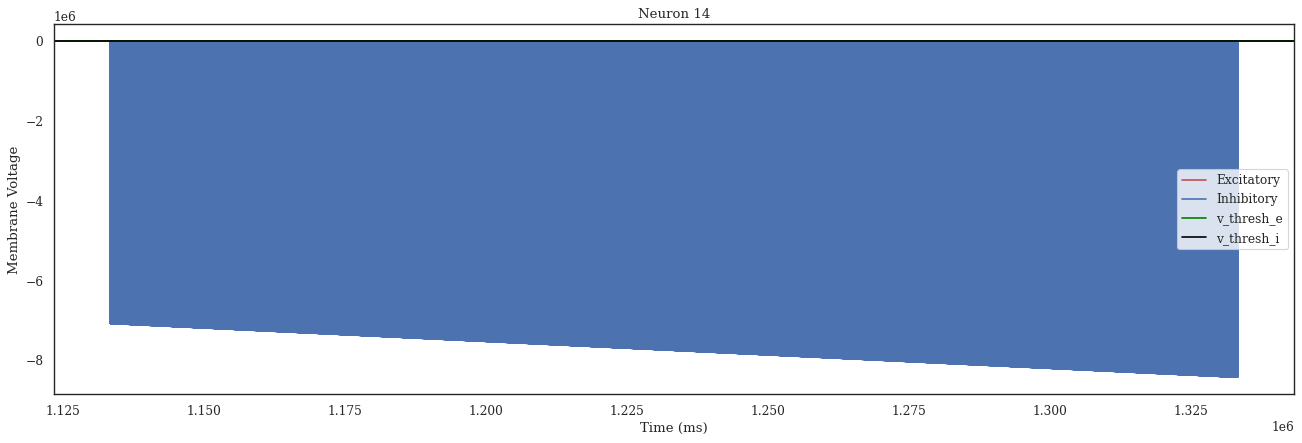

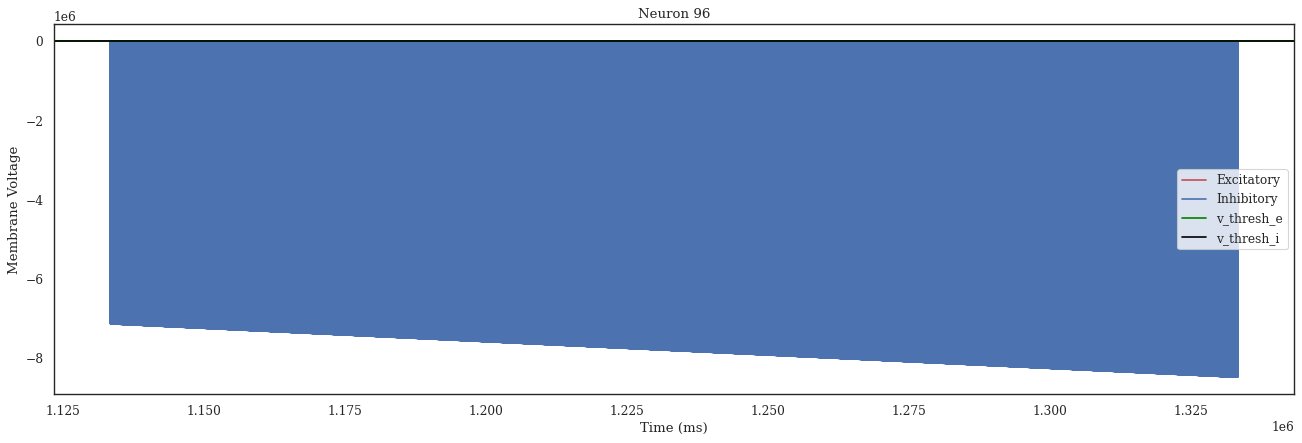

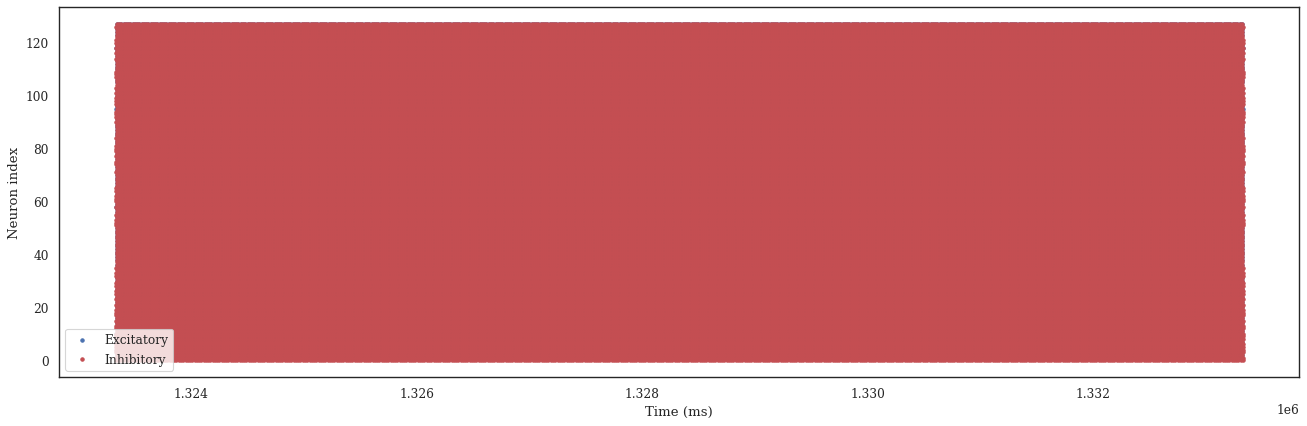

Presenting labels to network...
.... starting presentation/labeling phase ...
0
10
20
30
40
50
60
70
80
90
(100, 100)
(100,)
(100,)


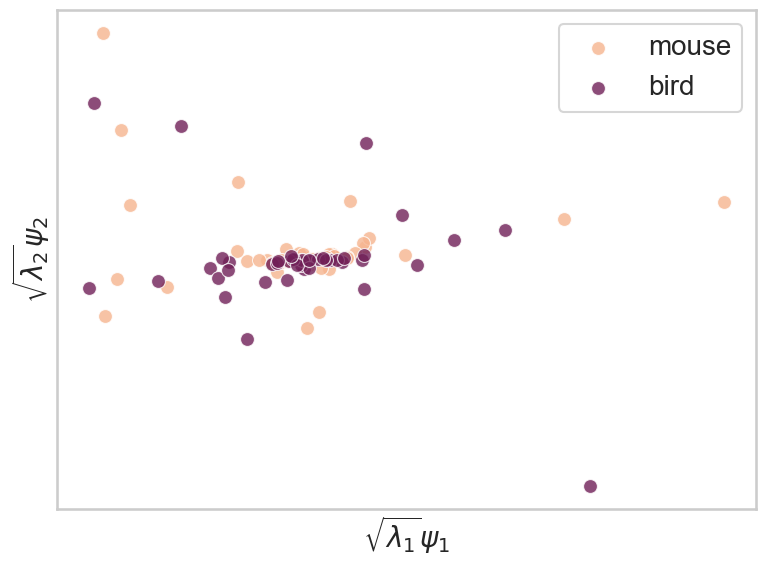

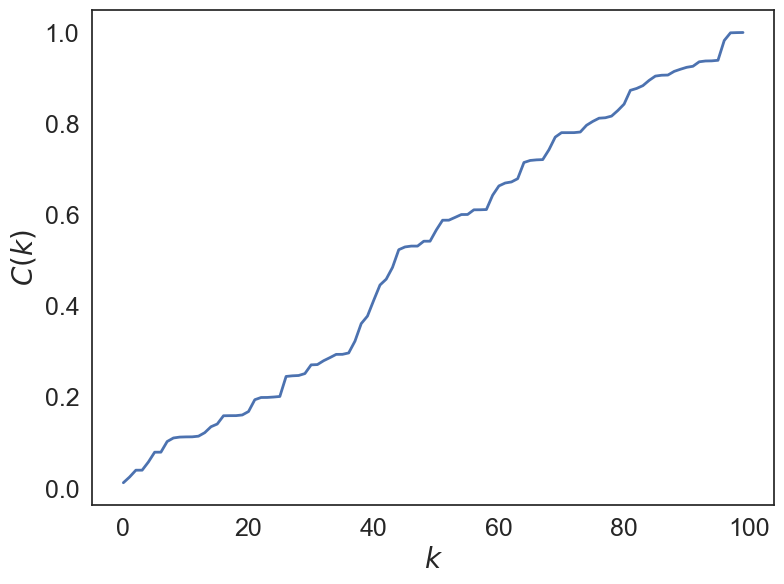

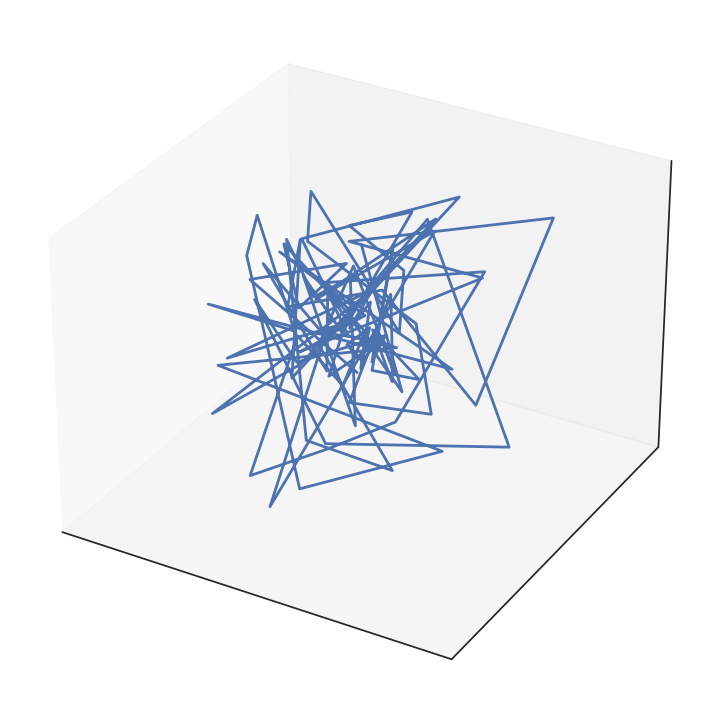

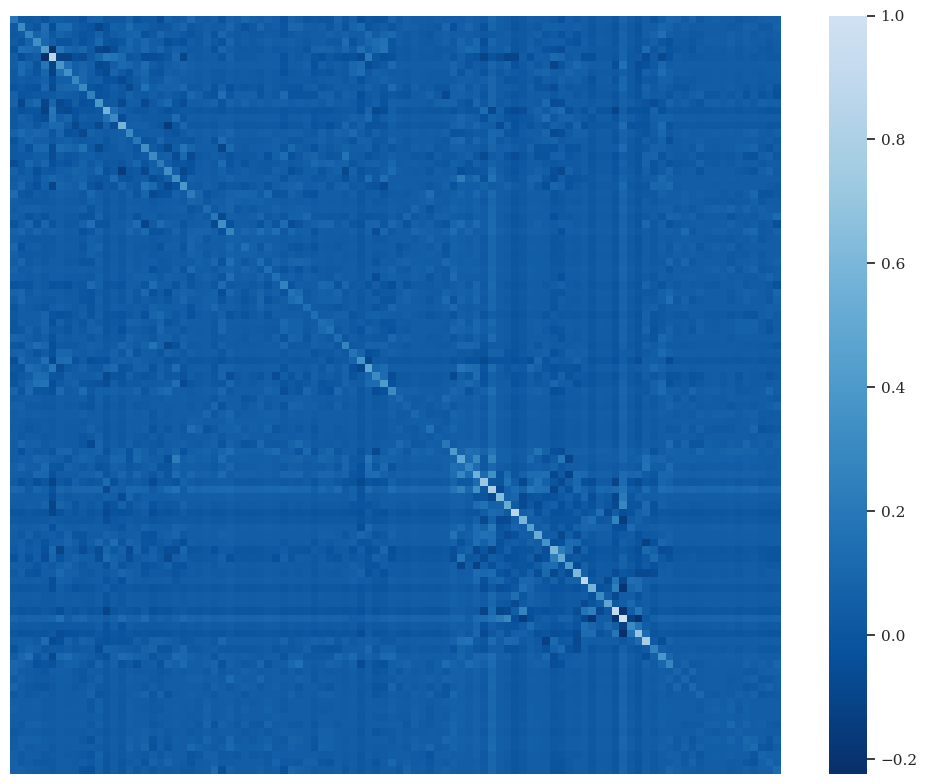

In [10]:
from brian2 import *
from snn_plotting import *
from utils import plot_kernel

def pre_test(neurons, train_items=50):
  '''
  function used to test the learning on a small training set (10) and visualize the output.
  '''
  seed()

  network = SNN(neurons, n_input=n_input, n_e=n_e, n_i=n_i)
  network.train(rates[:train_items])
  visualize(network, neurons)
  return network

neurons = np.random.randint(n_e, size=4)  # neurons to track


neurons = np.random.randint(n_e, size=4)  # Randomly select neurons to track
print("Selected neurons:", neurons)
# Loop over different training sizes
for P in [10, 25, 50, 100]:
    print(f"Running simulation for P = {P}...")

    # Normalize input data to [0, 1] for rate coding
    samples = np.random.choice(np.arange(resp_12.shape[0]), P, replace=False)
    responses = resp_12.copy()[samples, :]
    y_class = y[samples]
    rates = (responses - np.min(responses)) / (np.max(responses) - np.min(responses))



    # Pre-test and train the network
    network = pre_test(neurons, train_items=P)

    print('Presenting labels to network...')
    f_train = network.evaluate(rates)
    f_train = np.array(f_train)

    # Perform spectral decomposition
    K, s, v = sorted_spectral_decomp(f_train)

    # Plot results
    plot_top_2_eigenvectors(
       v, 
       y_class, 
       fig_name=f'top_2_eigenvectors_snn_{P}_patterns.pdf', 
       title_postfix=f' (SNN, {P} Patterns)',
       fig_dir='./snn_figures/'
    )
    plot_power(
       v, 
       y_class, 
       fig_name=f'power_snn_{P}_patterns.pdf', 
       title_postfix=f' (SNN, {P} Patterns)',
       fig_dir='./snn_figures/'
    )
    plot_3d_projected_response(
        f_train.T,
        fig_name=f'3d_projection_snn_codes_{P}_patterns.pdf',
        title_postfix=f' in SNN Kernel with {P} Patterns',
        fig_dir='./snn_figures/'
    )
    plot_kernel(
        K,
        fig_name=f'kernel_snn_{P}_patterns.pdf',
        title_postfix=f' in SNN Kernel with {P} Patterns',
        fig_dir='./snn_figures/'
    )

In [11]:
f_train.shape

(100, 128)